This notebook is written by Brittaney Everitt 10211957



The DarkCovidNet code comes from the author's Github at: https://github.com/muhammedtalo/COVID-19

Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

In [ ]:
#from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [ ]:
#ignore warnings
#not in original code
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.
from fastai.imports import *
from fastai.vision import *

In [ ]:
#I do this so that I can load the images in the next cell 
#This cell was not in the original code 
from google.colab import drive 
drive.mount('/content/drive/') 

Mounted at /content/drive/


# Load Data In 


Create Training and Validation Split


In [ ]:
#split files into training set and validation set
#this cell is not in the original code

!pip install split-folders

In [ ]:
import splitfolders 

# not in original code
# split into training and validation set 80% training and 20% validation like in the paper
# seed makes the spit reproducible 
# classes are evenly distributed in the split 
# creates the "imagenet style dataset"
# this only has to be run once 
splitfolders.ratio("drive/MyDrive/COVID-19/X-Ray_Image_DataSet", output="output", seed=1337, ratio=(.8, .2), group_prefix=None) # default values


Copying files: 1502 files [07:13,  3.46 files/s]


In [ ]:
#This code saves the above file output as a zip file 
!zip -r /content/output.zip /content/output

In [ ]:
#Path to the saved X-ray dataset (from the cell above) that is split into train and validation sets 
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.
path = Path('drive/MyDrive/COVID-19/content_SplitData/output') 
print(path.ls())

[PosixPath('drive/MyDrive/COVID-19/content_SplitData/output/val'), PosixPath('drive/MyDrive/COVID-19/content_SplitData/output/train')]


In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#Random seed makes the split the same every time for reproducibility 
np.random.seed(41)

#ImageDataBunch is a class that loads in data
#Data is formated in the "Imagenet-style dataset" a train folder with subfolders of each class and the same for validation 
#path is the path to the data, with folders labelled 'train' and 'val'
#size of the images is size=(256,256)
#batch size is 32 
#normalizes the data based on the mean and stand deviation using the Standard score, using predfeind stats
#get_transforms() is a list of transforms that can be used, but it is empty
#num_workers is workers that are retrieving the data
data = ImageDataBunch.from_folder(path, train="train", valid ="val",
        ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=4).normalize()

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#display number of classes, number of images in training and validation sets to make sure all data is correctly loaded in 
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings', 'Pneumonia'], 3, 1201, 301)

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#display the number of images in the split 
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 1201
Number of examples in validation: 301


In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#get data from one batch
xb,yb = data.one_batch()
#display the shape 
xb.shape,yb.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

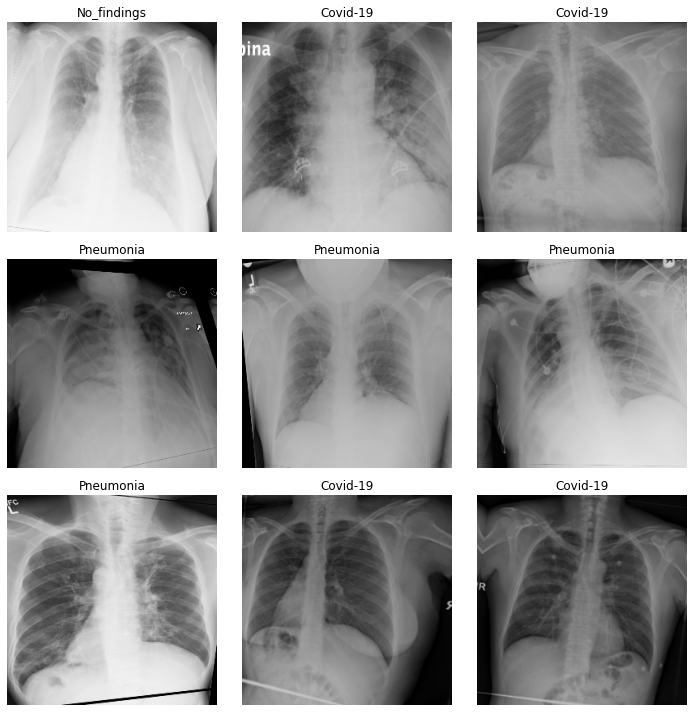

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#show images from the batch with labels
data.show_batch(rows=3, figsize=(10,10))

# Model 1: DarkCovidNet 
- This model usees the balanced dataset (about 500 COVID-19 images)


In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#This function defines the DarkCovidNet block 
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        #batch normalization over mini-batches with learnable parameters 
        nn.BatchNorm2d(nf),
        #angle of netative slope is 0.1 and the operation is done in place 
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#This function defines three DarkCovidNet blocks in a row 
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#This function defines the max pooling hyperparameters to use
def maxpooling():
    #pool size of 2, stride of 2
    return nn.MaxPool2d(2, stride=2)

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#This function sets up the sequential CNN DarkCovidNet architecture 
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 3),
    Flatten(),
    nn.Linear(507, 3),
)

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#This sets up the model specificying the data to use, model, cross entropy loss and metrics to visualize
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#Print the overall architecture of the model and visualize the shape of each output 
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#train with 100 epochs and max learning rate of up to 0.0003
learn.fit_one_cycle(100, max_lr=3e-3)

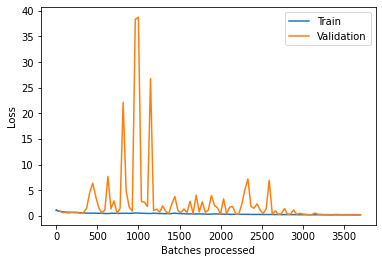

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#plots the train and validation loss after all of the training is over
learn.recorder.plot_losses()

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 301


In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#run the validation data through the model
probs,targets = learn.get_preds(ds_type=DatasetType.Valid) # Predicting without test time augmentation (random modifications to test images)

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#show the accuracy of the probs and targets 
accuracy(probs,targets)

tensor(0.8804)

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#display data in the validation set 
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings', 'Pneumonia'], 3, 1201, 301)

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#This code gets the label from each class from the probs array 
probs = np.argmax(probs, axis=1)
#determine how many labels correctly match 
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

#display confusion matrix
from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) # shows whole confusion matrix
cm1 = confusion_matrix(targets, probs)
print(cm1)

#display classification report with the three class labels 
from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings', 'Pneumonia']
print(classification_report(y_true1, y_pred1, target_names=target_names))

#show macro precision
from sklearn.metrics import precision_score
print('Precision',precision_score(y_true1, y_pred1, average='macro'))

# show the macro f1 score 
from sklearn.metrics import f1_score
print('F1-score',f1_score(y_true1, y_pred1, average='macro'))


301 265 0.8803986710963455
[[90  1  9]
 [ 0 88 12]
 [ 0 14 87]]
              precision    recall  f1-score   support

    Covid-19       1.00      0.90      0.95       100
 No_findings       0.85      0.88      0.87       100
   Pneumonia       0.81      0.86      0.83       101

    accuracy                           0.88       301
   macro avg       0.89      0.88      0.88       301
weighted avg       0.89      0.88      0.88       301

Precision 0.8866414958647969
F1-score 0.8822997933705737


In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#creates an interpreter object of the validation data from the model 
interp = ClassificationInterpretation.from_learner(learn)

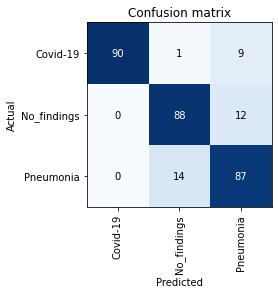

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#display the confusion matrix of the validation data 
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);

# Model 2 - Adding more layers 
- In this section of the code, I modify the DarkCovidNet architecure (from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792)

- The model uses the balanced dataset (about 500 COVID-19 images)

- I added two triple convolution blocks with output size 128 and 256 respectively, so that there are now three triple convolution blocks after the final max pooling layer
- I also add an additional Linear layer (fully connected layer) after the Flattened layer with a LeakyRelu activation function in the middle of the two Linear layers. 


In [ ]:
#This code is a modified version of code from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

model2 = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    triple_conv(256,128),
    triple_conv(128,256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 3),
    Flatten(),
    nn.Linear(867,507),
    nn.LeakyReLU(negative_slope=0.1, inplace=True),
    nn.Linear(507, 3),
)


In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#This sets up the model specificying the data to use, model, cross entropy loss and metrics to visualize
learn = Learner(data, model2, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#Print the overall architecture of the model and visualize the shape of each output 
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#train with 100 epochs and max learning rate of up to 0.0003
learn.fit_one_cycle(100, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.956179,1.146116,0.362126,00:49
1,0.871156,0.898731,0.624585,00:48
2,0.814958,0.710147,0.694352,00:48
3,0.772132,0.607341,0.750831,00:49
4,0.720103,1.321596,0.491694,00:50
5,0.695716,0.657687,0.681063,00:50
6,0.700417,0.563557,0.740864,00:51
7,0.720811,0.671453,0.737542,00:51
8,0.726814,0.695471,0.687708,00:53
9,0.705503,0.677390,0.730897,00:51


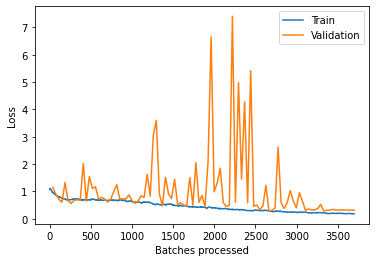

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#plots the train and validation loss after all of the training is over
learn.recorder.plot_losses()

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 301


In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#run the validation data through the model
probs,targets = learn.get_preds(ds_type=DatasetType.Valid) # Predicting without TTA

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#show the accuracy of the probs and targets 
accuracy(probs,targets)

tensor(0.8870)

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#This code gets the label from each class from the probs array 
probs = np.argmax(probs, axis=1)

#determine how many labels correctly match 
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

#display confusion matrix
from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) # shows whole confusion matrix
cm1 = confusion_matrix(targets, probs)
print(cm1)

#display classification report with the three class labels 
from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings', 'Pneumonia']
print(classification_report(y_true1, y_pred1, target_names=target_names))

#show macro precision
from sklearn.metrics import precision_score
print('Precision',precision_score(y_true1, y_pred1, average='macro'))

# show the macro f1 score 
from sklearn.metrics import f1_score
print('F1-score',f1_score(y_true1, y_pred1, average='macro'))


301 267 0.8870431893687708
[[92  1  7]
 [ 0 93  7]
 [ 0 19 82]]
              precision    recall  f1-score   support

    Covid-19       1.00      0.92      0.96       100
 No_findings       0.82      0.93      0.87       100
   Pneumonia       0.85      0.81      0.83       101

    accuracy                           0.89       301
   macro avg       0.89      0.89      0.89       301
weighted avg       0.89      0.89      0.89       301

Precision 0.8923918387413963
F1-score 0.888020026532574


In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#creates an interpreter object of the validation data from the model 
interp = ClassificationInterpretation.from_learner(learn)

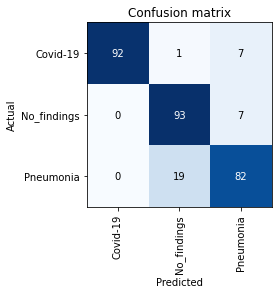

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#display the confusion matrix of the validation data 
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);

# Model 3 - Decreasing the depth of the model 

- Please note this model was added after the code demo Teams meeting with the TA

- In this section of the code, I modify the DarkCovidNet architecure (from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792)

- The model uses the balanced dataset (about 500 COVID-19 images)

- I modified the kernel output sizes of each layer, starting at 64 instead of 8. 

- From the original DarkCovidNet model, I removed the last triple convolution block and one of the final convolutional blocks deep in the network. 

- I also add an additional Linear layer (fully connected layer) after the Flattened layer with a LeakyRelu activation function in the middle of the two Linear layers.


In [ ]:
#This code is a modified version of code from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

model3 = nn.Sequential(
    conv_block(3, 64),
    maxpooling(),
    conv_block(64, 128),
    maxpooling(),
    triple_conv(128, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    maxpooling(),
    conv_block(256, 128, size=1),
    conv_layer(128, 3),
    Flatten(),
    nn.Linear(363,507),
    nn.LeakyReLU(negative_slope=0.1, inplace=True),
    nn.Linear(507, 3),
)

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#This sets up the model specificying the data to use, model, cross entropy loss and metrics to visualize
learn = Learner(data, model3, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#Print the overall architecture of the model and visualize the shape of each output
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 256, 256]       1,728      True      
______________________________________________________________________
BatchNorm2d          [64, 256, 256]       128        True      
______________________________________________________________________
LeakyReLU            [64, 256, 256]       0          False     
______________________________________________________________________
MaxPool2d            [64, 128, 128]       0          False     
______________________________________________________________________
Conv2d               [128, 128, 128]      73,728     True      
______________________________________________________________________
BatchNorm2d          [128, 128, 128]      256        True      
______________________________________________________________________
LeakyReLU            [128, 128, 128]      0          False     
___________________________________________________

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#train with 100 epochs and max learning rate of up to 0.0003
learn.fit_one_cycle(100, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.922230,1.056178,0.428571,02:29
1,0.797044,0.700684,0.684385,00:45
2,0.735586,0.738262,0.694352,00:45
3,0.699087,0.521081,0.790698,00:45
4,0.597956,1.767123,0.438538,00:45
5,0.554327,1.075117,0.495017,00:45
6,0.524509,0.539673,0.767442,00:46
7,0.522224,0.884734,0.621262,00:46
8,0.494858,1.429947,0.498339,00:46
9,0.513621,1.347185,0.571429,00:46


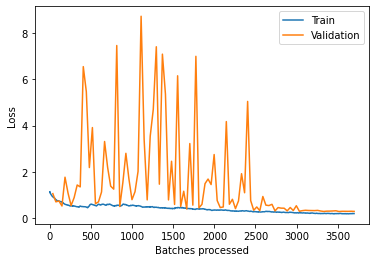

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#plots the train and validation loss after all of the training is over
learn.recorder.plot_losses()

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#run the validation data through the model
probs,targets = learn.get_preds(ds_type=DatasetType.Valid) # Predicting without TTA

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#show the accuracy of the probs and targets 
accuracy(probs,targets)

tensor(0.8837)

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#This code gets the label from each class from the probs array 
probs = np.argmax(probs, axis=1)

#determine how many labels correctly match 
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

#display confusion matrix
from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) # shows whole confusion matrix
cm1 = confusion_matrix(targets, probs)
print(cm1)

#display classification report with the three class labels
from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings', 'Pneumonia']
print(classification_report(y_true1, y_pred1, target_names=target_names))

#show macro precision
from sklearn.metrics import precision_score
print('Precision',precision_score(y_true1, y_pred1, average='macro'))

# show the macro f1 score 
from sklearn.metrics import f1_score
print('F1-score',f1_score(y_true1, y_pred1, average='macro'))

301 266 0.8837209302325582
[[93  1  6]
 [ 0 84 16]
 [ 0 12 89]]
              precision    recall  f1-score   support

    Covid-19       1.00      0.93      0.96       100
 No_findings       0.87      0.84      0.85       100
   Pneumonia       0.80      0.88      0.84       101

    accuracy                           0.88       301
   macro avg       0.89      0.88      0.89       301
weighted avg       0.89      0.88      0.89       301

Precision 0.8892603944150336
F1-score 0.8853816965434032


In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#creates an interpreter object of the validation data from the model 
interp = ClassificationInterpretation.from_learner(learn)

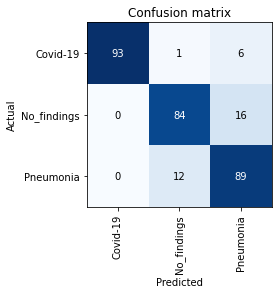

In [ ]:
#This code is from Ozturk T, Talo M, Yildirim EA, Baloglu UB, Yildirim O, Acharya UR. Automated detection of COVID-19 cases using deep neural networks with X-ray images. Computers in biology and medicine. 2020 Jun 1;121:103792.

#display the confusion matrix of the validation data 
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);